In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, Lambda
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns


# # 파일 업로드
#uploaded = files.upload()

# csv 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/nongbu/dataset.csv')

# 정규화함수
def normalization(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

min_price = np.min(df['price']);
max_price = np.max(df['price'])
# 가격 역정규화 함수
def denormalization(pred):
    return (pred * (max_price - min_price + 1e-7)) + min_price

# print(df.corrwith(df['price'], method='spearman'))

# 데이터 정규화
df = normalization(df) 

# train set / test set 분할
x_train, x_test, y_train, y_test = train_test_split(df.drop('price', 1), df['price'], test_size=0.2, random_state=0, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(655, 19) (655,)
(164, 19) (164,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [2]:
# 하이퍼 파라미터 정의
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE= 10   # 몇개의 과거 데이터 사용할것?
BATCH_SIZE= 7   # 몇개로 그룹지어 학습시킬거?

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (7, 10, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (7, 1)


In [3]:
# # 모델 생성

# 모델 생성
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, 
           kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(50, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])


model.compile(loss='mse', optimizer='sgd')

# 모델확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17,625
Trainable params: 17,625
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 10번의 epoch동안 val_loss 개선이 없다면 학습을 멈춘다.
earlystopping = EarlyStopping(monitor='val_loss', patience=30)

# val_loss 기준 체크포인터 설정
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

# 모델 학습
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     90/Unknown - 6s 12ms/step - loss: 0.0233 - mse: 0.0467
Epoch 1: val_loss improved from inf to 0.01134, saving model to tmp/ckeckpointer.ckpt
93/93 [==============================] - 8s 35ms/step - loss: 0.0229 - mse: 0.0459 - val_loss: 0.0113 - val_mse: 0.0227
Epoch 2/100
92/93 [============================>.] - ETA: 0s - loss: 0.0081 - mse: 0.0163
Epoch 2: val_loss improved from 0.01134 to 0.01127, saving model to tmp/ckeckpointer.ckpt
93/93 [==============================] - 2s 15ms/step - loss: 0.0081 - mse: 0.0163 - val_loss: 0.0113 - val_mse: 0.0225
Epoch 3/100
91/93 [============================>.] - ETA: 0s - loss: 0.0076 - mse: 0.0151
Epoch 3: val_loss improved from 0.01127 to 0.01125, saving model to tmp/ckeckpointer.ckpt
93/93 [==============================] - 2s 16ms/step - loss: 0.0075 - mse: 0.0151 - val_loss: 0.0113 - val_mse: 0.0225
Epoch 4/100
90/93 [============================>.] - ETA: 0s - loss: 0.0071 - mse: 0.0143
Epoch 4: val_loss improved from 

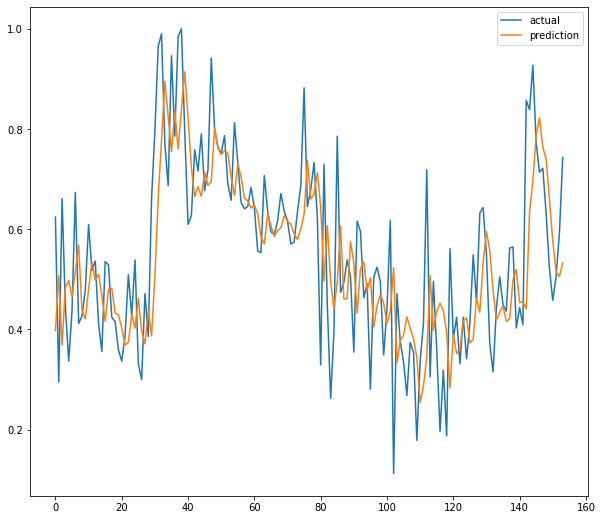

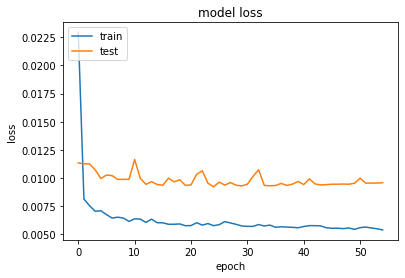

In [5]:
# 결과값
pred = model.predict(test_data)
pred.shape

# 실제, 예측 비교 그래프
plt.figure(figsize=(10, 9))
plt.plot(np.asarray(y_test)[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()


## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 역정규화
# print(denormalization(pred[-1]))